In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import isnan
from sklearn import svm
from sklearn import preprocessing
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, auc, r2_score
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, SVMSMOTE
from sklearn.feature_selection import RFE, RFECV
from numpy import savetxt, loadtxt
from numpy import mean, std
import math
import seaborn as sns
from utils import extract_stat_per_hemis, histogram_feature, median_imputation
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline


### Read data that was generated with Weighted-mean (based on Mahalanobis distance) Profile

In [2]:
data = pd.read_csv('my_table_patients_mahalanobisprofile_measure.csv') 

In [3]:
data_metrics = data.loc[:,['Sub_ID','loc','motor_status',
                           'ADP','ADCP','FAP','FDP','RDP',
                           'ADH','ADCH','FAH','FDH','RDH']]

In [4]:
X = np.asarray(data_metrics.pivot(index=["Sub_ID"], columns="loc", values=["ADP","ADCP","FAP","FDP","RDP",
                                                                           "ADH","ADCH","FAH","FDH","RDH"]))
y = data_metrics.loc[:,'motor_status'].values.reshape(116,-1)[:,0]

In [5]:
# number of selected features usinf SVM-RFE
n_features = 5
# number of the repetition (experiments)
n_repeats = 1500
# number of extracted features from both ipsi- and contralesional CST profiles
n_histo_features = 40
# number of synthetic dataset per fold
bag_number = 1000

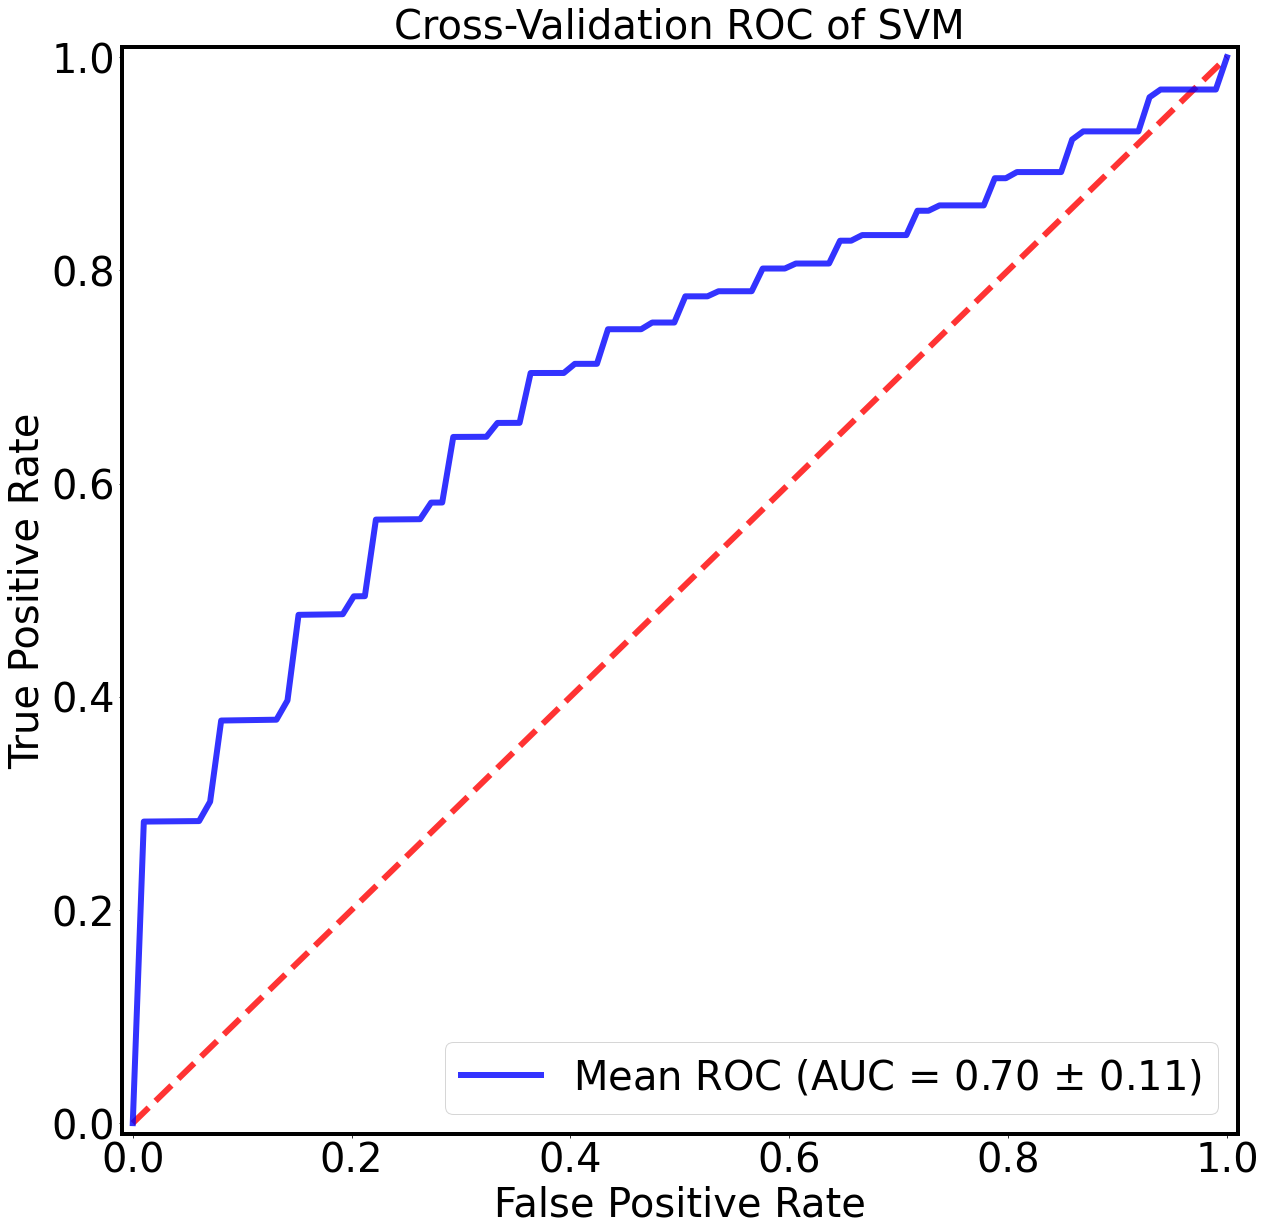

<Figure size 432x288 with 0 Axes>

In [6]:
feature_ranking = np.zeros(shape=(n_repeats*bag_number*10, n_histo_features))
#feature_ranking_bag = np.zeros(shape=(bag_number*10, n_histo_features))

accuracy = list()
sensitivity = list()
precision = list()
specificity = list()
    
tns = list()
fps = list()
tps = list()
fns = list()
scaler = StandardScaler()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(20,20))

cv_outer = RepeatedStratifiedKFold(n_splits=10, n_repeats=n_repeats, random_state=1)
iter_ = 0
for i,(train_ix, test_ix) in enumerate(cv_outer.split(X,y)):
    
    y_test = y[test_ix]
    X_test = X[test_ix, :]
    yhat_d = dict()
    prediction_d = dict()
    
    # generate 1000 synthetic from training fold
    for bag in range(bag_number):
    
        X_train, y_train = resample_with_replacement(train_ix, X, y)

        # imputation of missing values and feature extraction
        # choose k=10
        X_train_hist, X_test_hist = KNN_imputation(10, X_train, X_test)

        # feature normalization
        X_train_hist = scaler.fit_transform(X_train_hist)
        X_test_hist = scaler.transform(X_test_hist)


        model_orig = svm.SVC(kernel='linear', class_weight='balanced', probability=True) 
        rfe_model = svm.SVC(kernel='linear',class_weight='balanced')
        rfe = RFE(estimator=rfe_model, n_features_to_select=n_features)

        rfe_fs = rfe.fit(X_train_hist, y_train)
        x_train_rfe = rfe_fs.transform(X_train_hist)
        x_test_rfe = rfe_fs.transform(X_test_hist)

        feature_ranking[iter_,np.argwhere(rfe_fs.ranking_==1).ravel()] = 1

        search_space = {'C': np.arange(0.1,10,0.1).tolist()} 
        cv_inner = RepeatedStratifiedKFold(n_splits=5, random_state=1)

        search = GridSearchCV(estimator=model_orig, param_grid=search_space, cv=cv_inner, refit=True)
        result = search.fit(x_train_rfe, y_train)
        best_model = result.best_estimator_

        # evaluate model on the hold out dataset    
        prediction = best_model.predict_proba(x_test_rfe)
        yhat = best_model.predict(x_test_rfe)

        fpr, tpr, t = roc_curve(y_test.reshape(-1,1), prediction[:, 1])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        acc = accuracy_score(y_test, yhat)    
        acc2 = recall_score(y_test, yhat)
        acc3 = precision_score(y_test, yhat)
        tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
        acc4 = (tn/(tn+fp)) 
        tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)

        accuracy.append(acc)
        sensitivity.append(acc2)
        precision.append(acc3)
        specificity.append(acc4)

        iter_ = iter_+1
        # report progress     
        # print('>Accuracy=%.3f Recall=%.3f Precision=%.3f Sensitivity=%.3f' % (acc, acc2, acc3, acc4))

# summarize the estimated performance of the model
#print('Accuracy: %.3f (%.3f)' % (mean(accuracy), std(accuracy)))
#print('Recall: %.3f (%.3f)' % (mean(sensitivity), std(sensitivity)))
#print('Precision: %.3f (%.3f)' % (mean(precision), std(precision)))
#print('Specificty: %.3f (%.3f)' % (mean(specificity), std(specificity)))

plt.figure(figsize=(20,20))
plt.plot([0,1],[0,1],linestyle = '--',lw = 6,color = 'r',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std),lw=6, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
plt.xlabel('False Positive Rate',fontsize = 40)
plt.ylabel('True Positive Rate',fontsize = 40)
plt.title('Cross-Validation ROC of SVM',fontsize = 40)
plt.legend(loc="lower right", prop={'size': 40})
plt.xlim([-0.01, 1.01]) 
plt.ylim([-0.01, 1.01]) 
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 4
plt.show()